In [13]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    os.environ['CUDA_VISIBLE_DEVICES'] = \
        os.environ['CUDA_VISIBLE_DEVICES'].split(',')[1]
    # '0,1,2,3,4,5'
    print(os.environ['CUDA_VISIBLE_DEVICES'])
    
!nvidia-smi

4,5
5
Fri Jan  5 13:23:33 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   46C    P0   276W / 300W |  30887MiB / 32510MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| 

In [248]:
import os
import itertools
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline, shell_scripts_template_slurm
from note_pruning import get_final_model_name
num_gpus = 1
job_duration = 6
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

test_run = 0
test_run = bool(test_run)

sort_by_list = []


# ### relies on `model_name`

# # model_name = 'llama-7b'; md = 'llama7b'
# # model_name = 'llama-7b+lora:r=256:a=256'; md = 'llama7b'
# # model_name = 'llama-7b+lora:r=256:a=4096+proj=4096'; md = 'llama7br256p4096'
# model_name = 'llama-7b+lora:r=512:a=11585+proj=4096'; md = 'llama7br512p4096'

# # model_name = 'llama2-7b+lora:r=256:a=256'; md = 'llama2:7b'
# # model_name = 'llama-7b+lima+lora:r=256:a=256'; md = 'llama7b'
# # model_name = 'mistral-7b+lora:r=256:a=256'; md = 'mistral7b'
# # model_name = 'all-mpnet-base-v2'; md = 'mpnet'
# # model_name = 'bge-large-en-v1.5'; md = 'bge'
# # model_name = 'codellama-7b+lora:r=256:a=256'; md = 'codellama7b'

# sort_by_list += [
#     'random_s=0', 'random_s=1', 'random_s=2',
# #     'log_prob', 'logit_margin', 'el2n_agg=mean', 'grad_loraB_l2n',
# #     'numtoks', 'ifd_and_log_pmi', 
# ]
# ###

##### does not rely on `model_name`.
model_name = ''
# md = 'llama7b'
# md = 'llama7br256p4096'
md = 'llama7br512p4096'
# md = 'pythia1br512p4096'

# subset_size = 50_000
# subset_size = 40_000
# subset_size = 20_000
# subset_size = 20_000
# subset_size = 10_000
# subset_size = 5_000
# subset_size = 3_000
# subset_size = 1_000
# subset_size = 500

sort_by_list += [ # search for optimal gamma
#     f'dedup_md={md}_emb=text+embedding',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd=mpnet',
#     f'dppmap_k=rbf_gamma=auto{subset_size}_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd=bge',
#     f'dppmap_k=vmf_gamma=auto{subset_size}_kmd={md}_kemb=text+embedding',
#     f'dppmap_k=rbf_gamma=auto{subset_size}_kmd={md}_kemb=grad+rp+loraB',
]
# sort_by_list += [
sort_by_list += [ # large enough gamma is optimal!
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet',
#     f'dppmap_k=vmf_gamma=1_kmd=mpnet_ord=random:s@0',
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=1_kmd={md}_kemb=grad+rp+loraB_ord=random:s@0',
#     f'dppmap_k=vmf_gamma=0.1_kmd={md}_kemb=grad+rp+loraB',
#     f'dppmap_k=vmf_gamma=0.1_kmd={md}_kemb=grad+rp+loraB_ord=random:s@0',
    f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding',
    f'dppmap_k=rbf_gamma=1e-3_kmd={md}_kemb=text+embedding_ord=random:s@0',
]
#####


dataset_list = [
    ## newer with max_seq_len<=2048 exactly
    'stanford_alpaca', 
    'sharegptv2',
    'wizardlmv2',
    'oasst1',
    'flan_v2',
    'dolly',
    'ultrachat200kv2',
    'lima',
    ## r512p4096 didnt generate output yet.
#     'tulu_v2',
#     'open_orca_slim',
    ## older
#     'wizardlm',
#     'flan2022_1m',
#     'tulu_v1_mix',
#     'ultrachat',
    ## coding
#     'starcoder_commentinstr', 
#     'starcoder_commentinstr_cleaned',
#     'starcoder_commentinstrv2',
#     'starcoder_commentinstrv2_flppl',
#     'starcoder_commentinstrv5',
]


from note_pruning_analysis import data_inds_dir

options_list = itertools.product(dataset_list, sort_by_list)

print('test_run =',test_run)
cmds = []
for dataset, sort_by in options_list:
    model_name_ = get_final_model_name(model_name, sort_by)
    save_dir = os.path.join(data_inds_dir, model_name_, dataset)
    cmd = f"""
     python note_pruning.py \
        --dataset {dataset} \
        --sort_by {sort_by} \
        --model_name {model_name_} \
        --save_dir {save_dir} \
    """.strip()
    cmd = multiline_to_singleline(cmd)
    shell_scripts = shell_scripts_template_slurm.format(
        conda_env='open-instruct',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'prune.{dataset}.{sort_by}', 
        nodes=1,
        num_cpus=64, # 32
        cpu_mem=400, # 128, total mem=700.
        num_gpus=num_gpus,
        gpu_type='v100',
        test_run=test_run,
        job_duration=job_duration,
    )
    cmds.append(cmd)
    print(cmd)
        
print('#cmds: ', len(cmds))


test_run = False

Submiting job with:
{
    "job_name": "prune.stanford_alpaca.dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 400,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset stanford_alpaca --sort_by dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding --model_name llama-7b+lora:r=512:a=11585+proj=4096 --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/stanford_alpaca

Submiting job with:
{
    "job_name": "prune.stanford_alpaca.dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding_ord=random:s@0",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 400,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset stanford_alpaca --s

python note_pruning.py --dataset ultrachat200kv2 --sort_by dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding_ord=random:s@0 --model_name llama-7b+lora:r=512:a=11585+proj=4096 --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2

Submiting job with:
{
    "job_name": "prune.lima.dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding",
    "nodes": 1,
    "num_cpus": 64,
    "cpu_mem": 400,
    "num_gpus": 1,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
python note_pruning.py --dataset lima --sort_by dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding --model_name llama-7b+lora:r=512:a=11585+proj=4096 --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/lima

Submiting job with:
{
    "job_name": "prune.lima.dppmap_k

In [54]:
with open('note_pruning_run_cmds.sh', 'w') as f:
    s = 'set -e\nset -x\n'
    devices = os.environ['CUDA_VISIBLE_DEVICES'].split(',')[-1]
    s += '\n\n'.join([f"CUDA_VISIBLE_DEVICES={devices} "+x for x in cmds])
    f.write(s)

In [55]:
!bash note_pruning_run_cmds.sh

+ CUDA_VISIBLE_DEVICES=2
+ python note_pruning.py --dataset lima --sort_by dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB_ord=random:s@0 --model_name llama-7b+lora:r=512:a=11585+proj=4096 --save_dir /gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/lima
/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')
{
  "dataset": "lima",
  "sort_by": "dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB_ord=random:s@0",
  "model_name": "llama-7b+lora:r=512:a=11585+proj=4096",
  "save_dir": "/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/data_inds/llama-7b+lora:r=512:a=11585+proj=4096/lima"
}
Calling note_pruning_dpp.compute_dppmap with kwargs={
    "dppmap_type": "dppmap",
    "dataset": "lima",
    "ker

### Generate curriculum from pre-computed scores (via `note_pruning.py`)

In [69]:
import itertools
from note_curriculum import (
    get_curriculum_scores,
    get_curriculum,
    generate_curriculum,
    generate_curriculum_forall_scoring_fn,
    scores_path_to_attrs,
    np_random_choice_maximize_noreplacement,
    plt_curriculum,
)
from note_pruning_analysis import assets_dir

# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000; num_epochs = 3
# model_name = 'llama-7b'; dataset = 'sharegpt'; M = 150_000; num_epochs = 3

## mistral+ultrachat
# model_name = 'mistral-7b'; dataset = 'ultrachat200k'; M = 50_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 200_000; num_epochs = 2

## semdedup
# model_name = 'bge-large-en-v1.5'; dataset = 'wizardlm'; M = 100_000; num_epochs = 2
# model_name = 'all-mpnet-base-v2'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2
# model_name = 'all-mpnet-base-v2'; dataset = 'tulu_v1_mix'; M = 150_000; num_epochs = 2
# model_name = 'mistral-7b'; dataset = 'ultrachat15'; M = 100_000; num_epochs = 2

## starcoder
# M = 25_000; num_epochs=5; model_name = ['codellama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['starcoder_commentinstr_cleaned', 'starcoder_commentinstr']
# M = 50_000; num_epochs=5; model_name = ['codellama-7b', 'all-mpnet-base-v2']; \
#     dataset = ['starcoder_commentinstrv2']

## wizardlm
# model_name = ['llama-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5']; dataset = ['wizardlm']
# M = 100_000; num_epochs = 2
# M = 50_000; num_epochs = 5
# M = 10_000; num_epochs = 10

## tulu_v1_mix
# model_name = ['llama-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5']; dataset = ['tulu_v1_mix']
# M = 50_000; num_epochs = 5
# M = 150_000; num_epochs = 3

## tulu_v2, open_orca_slim, sharegptv2
model_name = ['llama-7b', 'llama2-7b', 'all-mpnet-base-v2', 'bge-large-en-v1.5', 'codellama-7b', 'pythia-1b']
# dataset = ['tulu_v2']
# dataset = ['open_orca_slim']
# dataset = ['sharegptv2']
# dataset = ['stanford_alpaca']
# dataset = ['lima']
# dataset = ['flan_v2']
# dataset = ['oasst1']
# dataset = ['wizardlmv2']
# dataset = ['ultrachat200kv2']
# dataset = ['dolly']
# dataset = ['stanford_alpaca', 'oasst1', 'wizardlm']
# dataset = ['starcoder_commentinstrv5']

model_name = ['llama-7b+lora:r=512:a=11585+proj=4096']
dataset = [
    'dolly',
    'flan_v2',
    'oasst1',
    'sharegptv2',
    'stanford_alpaca',
    'ultrachat200kv2',
    'wizardlmv2',
]


# M = 60_000; num_epochs = 3 # ->20k
# M = 50_000; num_epochs = 5 # ->10k
M = 10_000; num_epochs = 10 # ->1k



pacing_fn_list = [
#     f'prune_size={M}_ep=1',
    f'prune_size={M}_ep={num_epochs}',
#     f'prune_size={M}_ep=3',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.05',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
]

output_list = generate_curriculum_forall_scoring_fn(
    model_name, dataset, pacing_fn_list, verbose=False)

save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/sharegptv2/random_s=0_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/sharegptv2/dppmap_k=vmf_gamma=auto10000_kmd=llama7br512p4096_kemb=grad+rp+loraB/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/sharegptv2/dppmap_k=rbf_gamma=1_kmd=llama7br512p4096_kemb=text+embedding/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/sharegptv2/random_s=2_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/sharegptv2/dppmap_k=rbf_gamma=auto10000_kmd=llama7br512p4096_kemb=text+embedding/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/sharegptv2/random_s=1/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000)

save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/wizardlmv2/dppmap_k=vmf_gamma=1_kmd=llama7br512p4096_kemb=grad+rp+loraB/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=0_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/dppmap_k=vmf_gamma=auto10000_kmd=llama7br512p4096_kemb=grad+rp+loraB/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=2_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/dppmap_k=rbf_gamma=auto10000_kmd=llama7br512p4096_kemb=text+embedding/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/flan_v2/random_s=1/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/l

save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/ultrachat200kv2/dppmap_k=vmf_gamma=3.29e-05_kmd=llama7br512p4096_kemb=grad+rp+loraB/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/random_s=0_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/dppmap_k=vmf_gamma=auto10000_kmd=llama7br512p4096_kemb=grad+rp+loraB/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/dppmap_k=rbf_gamma=1e-3_kmd=llama7br512p4096_kemb=text+embedding/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/dppmap_k=rbf_gamma=1_kmd=llama7br512p4096_kemb=text+embedding/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=512:a=11585+proj=4096/oasst1/random_s=2_neg/inds_prune_size=10000

save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/dolly/random_s=1/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/dolly/log_prob_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/dolly/ifd_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/dolly/random_s=2/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/dolly/numtoks_total/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/dolly/dppmap_k=vmf_gamma=auto3000_kmd=llama7b_kemb=grad+rp+loraB/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/dolly/ifd/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/dolly/grad_loraB_l2n/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000

save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/stanford_alpaca/el2n_agg=mean/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/stanford_alpaca/log_pmi_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/stanford_alpaca/random_s=2_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/stanford_alpaca/numtoks_output_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/stanford_alpaca/dppmap_k=rbf_gamma=auto10000_kmd=llama7b_kemb=text+embedding/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/stanford_alpaca/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=text+embedding/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=256/stanford_alpaca/dppmap_k=rbf_gamma=auto1000_kmd=llama7b_kemb=g

save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=4096+proj=4096/stanford_alpaca/random_s=2_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=4096+proj=4096/stanford_alpaca/numtoks_output_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=4096+proj=4096/stanford_alpaca/random_s=1/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=4096+proj=4096/stanford_alpaca/log_prob_neg/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=4096+proj=4096/stanford_alpaca/random_s=2/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=4096+proj=4096/stanford_alpaca/numtoks_total/inds_prune_size=10000_ep=10.pkl
save inds (length = 10000) to curriculum/llama-7b+lora:r=256:a=4096+proj=4096/stanford_alpaca/grad_loraB_l2n/inds_prune_size=10000_ep=10.pkl
save inds (length = 

In [ ]:
import re
import numpy as np
from note_curriculum import get_curriculum_scores, generate_curriculum, plt_curriculum
import glob
import matplotlib.pyplot as plt

model_name = 'mistral-7b'; dataset = 'ultrachat'; M =  50_000
# model_name = 'llama-7b'; dataset = 'tulu_v1_mix'; M = 150_000


paths = glob.glob('curriculum/*/*/*/scores.pkl')
paths = [x for x in paths if 'llama' in x and 'tulu_v1_mix' in x and 'log_prob_neg' in x]
path = paths[0]

verbose = True
print(path)
pacing_fn = f'prune_size={M}_ep=3'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.1'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.2'
# pacing_fn = f'singlestep_size={M}_startingfrac=0.3'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.2_inc=1.5'
# pacing_fn = f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5'

pacing_fn_list = [
    f'prune_size={M}_ep=3',
    f'singlestep_size={M}_startingfrac=0.05',
#     f'singlestep_size={M}_startingfrac=0.1',
#     f'singlestep_size={M}_startingfrac=0.2',
#     f'singlestep_size={M}_startingfrac=0.3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=1.5',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.1_inc=3',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.5',
    f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=2',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=3',
#     f'fep_size={M}_nsteps=5_startingfrac=0.05_inc=1.25'
]



nrows = len(pacing_fn_list)
fig, axs = plt.subplots(nrows, 3, figsize=(15,3*nrows), sharey=False, gridspec_kw={'width_ratios': [2,.5,.5]})

for i, pacing_fn in enumerate(pacing_fn_list):

    plt_kwargs = generate_curriculum(path, pacing_fn, verbose=True, save_output=False)
    output = plt_kwargs.pop('output')
    plt_kwargs.update({'fig': fig, 'axs': axs[i]})
    plt_curriculum(**plt_kwargs)

fig.tight_layout()



save_plt = 0
if save_plt:
    model_name, dataset, scoring_fn = output['model_name'], output['dataset'], output['scoring_fn']
    save_path = os.path.join(
        assets_dir, f'note_curriculum_{model_name}:{dataset}:{scoring_fn}.png')
    fig.savefig(save_path, bbox_inches='tight', dpi=100)



curriculum/llama-7b+lora:r=256:a=256/tulu_v1_mix/log_prob_neg/scores.pkl
fixed exponential pacing startingfrac=0.05, inc=20.0, nsteps=2 
Implies: step_lens=[25000, 25000], stepwise_data_fracs=[0.05, 1.0]
fixed exponential pacing startingfrac=0.05, inc=1.5, nsteps=5 
Implies: step_lens=[10000, 10000, 10000, 10000, 10000], stepwise_data_fracs=[0.05, 0.07500000000000001, 0.1125, 0.16875, 0.253125]
fixed exponential pacing startingfrac=0.05, inc=2.0, nsteps=5 
Implies: step_lens=[10000, 10000, 10000, 10000, 10000], stepwise_data_fracs=[0.05, 0.1, 0.2, 0.4, 0.8]
Error in callback <function flush_figures at 0x7fff5ba411b0> (for post_execute):


### main code

In [14]:
import os
import sys
import numpy as np
import time
import re
import random
import json
import pickle
from tqdm import tqdm 

import pyarrow
import torch
import transformers
import pandas as pd

from note_pruning import (
    save_to_pickle,
    save_sorted_inds,
    sort_kmeans_dist_to_cluster_centers,
    save_prune_results,
)
from note_pruning_analysis import get_lm_output
from note_pruning_dpp import torch_vmf_kernel, torch_rbf_kernel
from functools import partial

from transformers import AutoTokenizer

from rosemary import parse_kv_from_string, create_string_from_kv
from note_pruning_analysis import lm_output_dir, get_dataset_token_lengths, get_full_model_name, md_to_model_name

import note_pruning_dpp
import note_pruning_clustering

In [15]:
test_run = False
dataset = 'tulu_v1_human_mix'
dataset = 'tulu_v2_human_mix'
dataset = 'flan_v2'
dataset = 'lima'
dataset = 'dolly'
# dataset = 'flan2022_1m'
# dataset = 'lima'
# dataset = 'ultrachat200k'
# dataset = 'tulu_v1_mix'
# dataset = 'wizardlm'
# dataset = 'ultrachat15'
# dataset = 'starcoder_commentinstr_cleaned'

sort_by = 'random_s=0'

# used for generating model output.
model_name = 'llama-7b'
# model_name = 'llama-7b_ft=hmv1'
# model_name = 'llama-7b+lora:r=256:a=256'
# model_name = 'llama-7b+lima+lora:r=256:a=256'
# model_name = 'mistral-7b+lora:r=256:a=256'
# model_name = 'all-mpnet-base-v2'
# model_name = 'bge-large-en-v1.5'
# model_name = 'codellama-7b+lora:r=256:a=256'


# save_dir = f"data_inds/"
# from note_pruning import get_final_model_name
# model_name_ = get_final_model_name(model_name, sort_by)
# save_dir = os.path.join(save_dir, model_name_, dataset)
# os.makedirs(save_dir, exist_ok=True) 

# print(dataset, model_name, sort_by)
# print(save_dir)

In [16]:
from note_pruning_dpp import get_dppmap_run_info
import re
import numpy as np
from rosemary import parse_kv_from_string, create_string_from_kv
from note_curriculum import get_curriculum_scores
from note_pruning_analysis import curriculum_dir
from note_pruning import get_dppmap_autotune_gamma_search_result
import note_pruning_dpp
import json
from note_pruning import parse_sort_by_and_compute_dppmap

kmd = 'llama7b'
kmd = 'llama7br512p4096'


dataset = 'stanford_alpaca'
gamma = 2e-4
# sort_by = f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@0'
# sort_by = f'dppmap_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@0'
# sort_by = f'dppmap_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@1'
# sort_by = f'dppmap_k=vmf_gamma={gamma}_kmd={kmd}_kemb=grad+rp+loraB'
# sort_by = f'dppmap_k=lin_gamma=1_kmd={kmd}_kemb=grad+rp+loraB'
# sort_by = f'dppmap_k=lin_gamma=10_kmd={kmd}_kemb=grad+rp+loraB'

# dataset = 'sharegptv2'
# sort_by = f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@1'


# parse_sort_by_and_compute_dppmap(sort_by, dataset)

In [97]:
from note_pruning import get_dppmap_autotune_gamma_search_result


dataset = 'lima'
kmd = 'llama7br512p4096'
sort_by = f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB'

d = get_dppmap_autotune_gamma_search_result(sort_by, dataset)
d

In [33]:

def get_dppmap_marginal_gains(sort_by, dataset):
    import pickle
    from note_pruning_analysis import scripts_dir
    from note_pruning import get_dppmap_autotune_gamma_search_result
    if 'gamma=auto' in sort_by:
        d = get_dppmap_autotune_gamma_search_result(sort_by, dataset)
        sort_by = re.sub(r'auto\d+', str(d['gamma']), sort_by)
    save_path = os.path.join(scripts_dir, 'dpp', dataset, sort_by, 'data.pkl')
    if not os.path.isfile(save_path):
        return None
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    di2s = np.array(data['marginal_gains'])
    marginal_gains = np.log(di2s) #+ np.log(1e10)
    return marginal_gains


dataset_list = [
#     'lima', 
    'dolly',
    'flan_v2',
    'oasst1',
    'sharegptv2',
    'stanford_alpaca',
    'ultrachat200kv2',
    'wizardlmv2',
]
kmd = 'llama7br512p4096'
# kmd = 'llama7b'
# sort_by = f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB'
# sort_by = f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB'
# ord_to_sort_by = {
# #     'random:s@0': sort_by+'_ord=random:s@0',
#     'greedy': sort_by,
# }
ord_to_sort_by = {
    ## vmf+grad
    'greedy': f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB',
    'random:s@0': f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@0',
#     'greedy': f'dppmap_k=vmf_gamma=0.1_kmd={kmd}_kemb=grad+rp+loraB',
#     'random:s@0': f'dppmap_k=vmf_gamma=0.1_kmd={kmd}_kemb=grad+rp+loraB_ord=random:s@0',
#     'gamma=1': f'dppmap_k=vmf_gamma=1_kmd={kmd}_kemb=grad+rp+loraB',
#     'gamma=auto1000': f'dppmap_k=vmf_gamma=auto1000_kmd={kmd}_kemb=grad+rp+loraB',
#     'gamma=auto10000': f'dppmap_k=vmf_gamma=auto10000_kmd={kmd}_kemb=grad+rp+loraB',
    ## rbf+text
#     'greedy': f'dppmap_k=rbf_gamma=1e-3_kmd={kmd}_kemb=text+embedding',
#     'random:s@0': f'dppmap_k=rbf_gamma=1e-3_kmd={kmd}_kemb=text+embedding_ord=random:s@0',
}

mgs = {
    (dataset, k): get_dppmap_marginal_gains(v, dataset) for k, v in ord_to_sort_by.items()
    for dataset in dataset_list
}
mgs = {k: v for k, v in mgs.items() if v is not None}
list(mgs.keys())

[('dolly', 'greedy'),
 ('flan_v2', 'greedy'),
 ('oasst1', 'greedy'),
 ('sharegptv2', 'greedy'),
 ('stanford_alpaca', 'greedy'),
 ('ultrachat200kv2', 'greedy'),
 ('wizardlmv2', 'greedy'),
 ('dolly', 'random:s@0'),
 ('flan_v2', 'random:s@0'),
 ('oasst1', 'random:s@0'),
 ('sharegptv2', 'random:s@0'),
 ('stanford_alpaca', 'random:s@0'),
 ('ultrachat200kv2', 'random:s@0'),
 ('wizardlmv2', 'random:s@0')]

/tmp/ipykernel_1617790/997478397.py:55: RuntimeWarning: divide by zero encountered in divide
  mg_ratio = mg_cumsum/mg_rand_cumsum


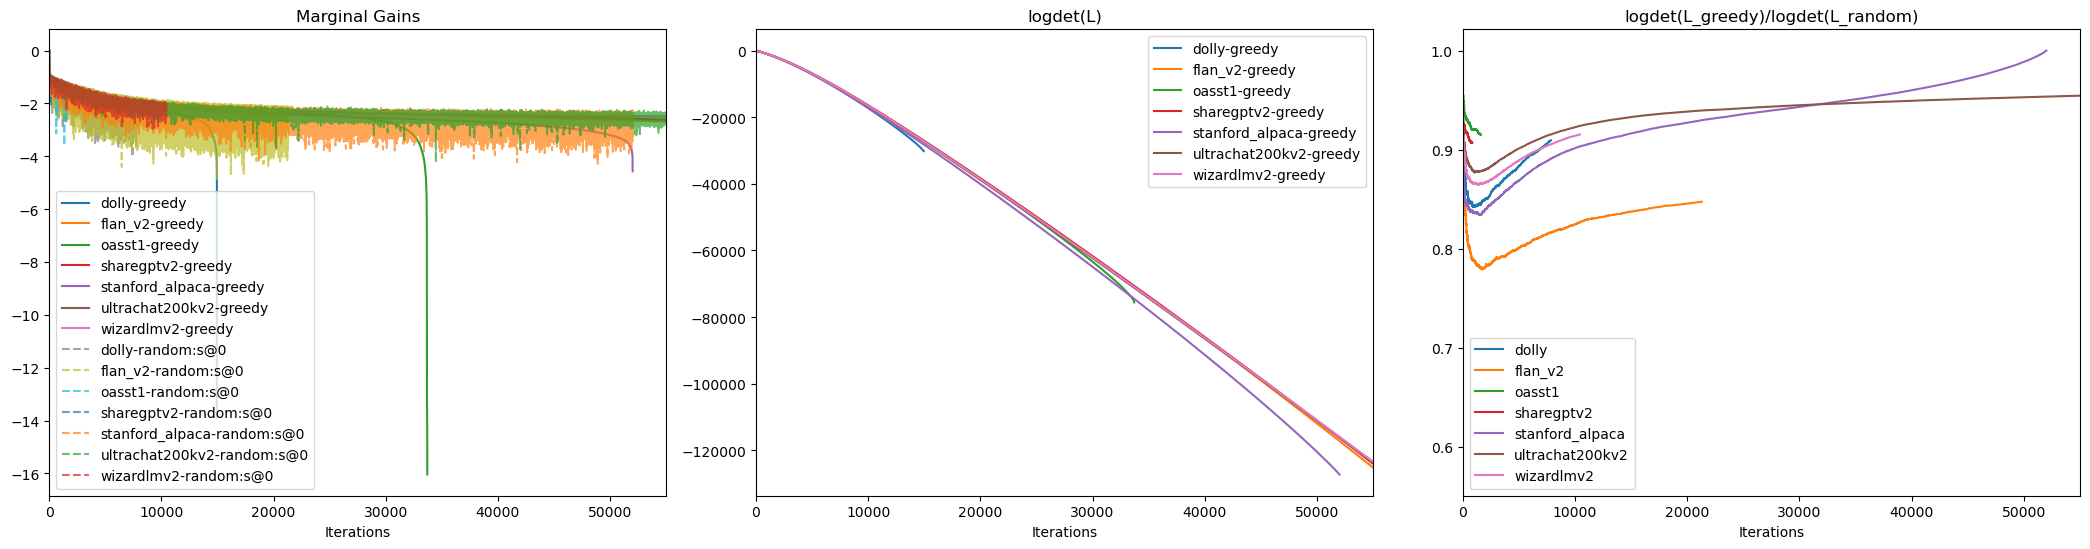

In [34]:
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale
import pickle

# xlim = (900, 1_100)
# xlim = (0, 5000)
# xlim = (1000-10, 1000+10)
# xlim = (10000-200, 10000+200)
# xlim = (10000-10, 10000+10)
# xlim = (30000-100, 30000+100)
# xlim = (50000-100, 50000+100)
# xlim = (0, 10_000)
xlim = (0, 55_000)
# xlim = (None, None)
xs = np.arange(xlim[0], xlim[1])


w = 7
fig, axs = plt.subplots(1, 3, figsize=(3*w,w*.8))

ax = axs[0]
for (dataset, ordering), ys in mgs.items():
#     if 'random' in ordering: continue
    label = f'{dataset}-{ordering}'
    xs_ = xs[xs<len(ys)]
    ys_ = ys[xs_]
    ax.plot(xs_, ys_, '--' if 'random' in ordering else '-', label=label, alpha=.7 if 'random' in ordering else 1)
ax.legend()
ax.set_xlim(xlim)
# if ys_[1] > 1:
#     ax.set_ylim((18, 23))
    


ax = axs[1]
for (dataset, ordering), ys in mgs.items():
    if 'random' in ordering: continue
    label = f'{dataset}-{ordering}'
    xs_ = xs[xs<len(ys)]
    ax.plot(xs_, np.cumsum(ys)[xs_], 'o-' if 'random' in ordering else '-', label=label, alpha=1)
ax.legend()
# ax.set_yscale('log')
ax.set_xlim(xlim)


ax = axs[2]
for dataset in dataset_list:
    if not all((dataset, x) in mgs for x in ['random:s@0', 'greedy']): continue
    mg_rand_cumsum = np.cumsum(np.log(np.abs(np.exp(mgs[(dataset, 'random:s@0')]))))
    mg_cumsum = np.cumsum(np.log(np.abs(np.exp(mgs[(dataset, 'greedy')]))))
    max_len = min(len(mg_rand_cumsum), len(mg_cumsum))
    xs_ = xs[xs<max_len]
    mg_rand_cumsum = mg_rand_cumsum[:max_len]
    mg_cumsum = mg_cumsum[:max_len]
    mg_ratio = mg_cumsum/mg_rand_cumsum
    ax.plot(xs_, mg_ratio[xs_], label=dataset)
    ax.set_xlim(xlim)
ax.legend()
ax.set_xlim(xlim)

axs[0].set_title('Marginal Gains')
axs[1].set_title('logdet(L)')
axs[2].set_title('logdet(L_greedy)/logdet(L_random)')

for i in range(3):
    axs[i].set_xlabel('Iterations')

    
fig.tight_layout()

/tmp/ipykernel_1617790/1492163840.py:40: RuntimeWarning: invalid value encountered in divide
  ax.plot(mg_cumsum/mg_rand_cumsum)


KeyError: 'random:s@0'

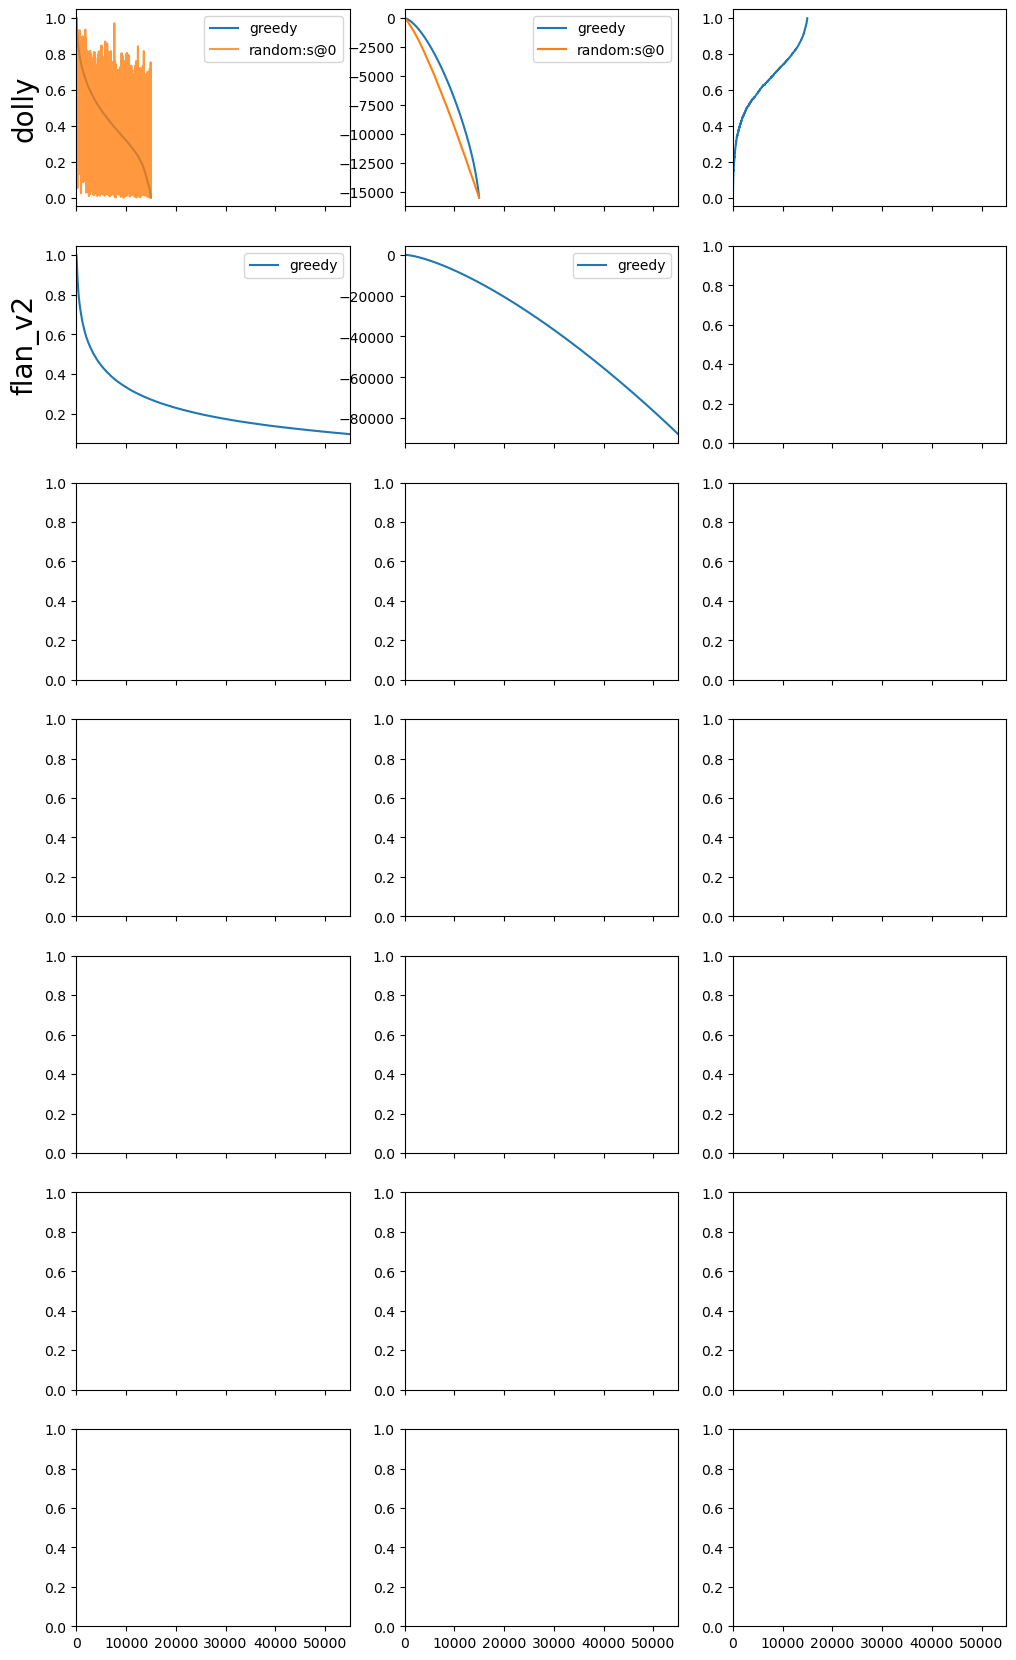

In [23]:
import matplotlib.pyplot as plt
import pickle


nrows = len(dataset_list)

fig, axs = plt.subplots(nrows, 3, figsize=(3*4,3*nrows), sharex=True)
axs = axs.reshape(-1, 3)

xlim = (0, 55_000)
# xlim = (None, None)
# xlim = (0, 10_000)
for i, dataset in enumerate(dataset_list):
    mgs_ds = {k[1]: mgs[k] for k in list(mgs.keys()) if k[0]==dataset}

    ax = axs[i,0]

    for k, mg in mgs_ds.items():
        ax.plot(np.exp(mg), label=k, alpha=1 if k=='greedy' else .8)
    ax.set_ylabel(dataset, fontsize=20)
    ax.legend()
    ax.set_xlim(xlim)
#     ax.set_ylim((18, 23))

    ax = axs[i, 1]
    for k, mg in mgs_ds.items():
        ax.plot(np.cumsum(mg), label=k)
    ax.legend()
    ax.set_xlim(xlim)
#     ax.set_ylim((0, 1e6))
    
    ax = axs[i, 2]
#     mg_rand_cumsum = np.abs(np.cumsum(mgs_ds['random:s@0']))
#     mg_cumsum = np.abs(np.cumsum(mgs_ds['greedy']))
    mg_rand_cumsum = np.cumsum(np.log(np.abs(np.exp(mgs_ds['random:s@0']))))
    mg_cumsum = np.cumsum(np.log(np.abs(np.exp(mgs_ds['greedy']))))
    max_len = min(len(mg_rand_cumsum), len(mg_cumsum))
    mg_rand_cumsum = mg_rand_cumsum[:max_len]
    mg_cumsum = mg_cumsum[:max_len]
    ax.plot(mg_cumsum/mg_rand_cumsum)
    ax.set_xlim(xlim)
#     ax.set_ylim((1, 1.02))
    # ax.plot(mg_cumsum-mg_rand_cumsum)
    

# Share y-axis for the second column
for i in range(1, nrows):
    axs[i, 1].get_shared_y_axes().join(axs[i, 1], axs[0, 1])

    
axs[0, 0].set_title('Marginal Gains')
axs[0, 1].set_title('logdet(L)')
axs[0, 2].set_title('|logdet(L_greedy)|/|logdet(L_random)|')
    

# fig.suptitle(sort_by)
fig.tight_layout()

In [1]:
import pickle
dataset = 'stanford_alpaca'
sort_by = 'dppmap_k=vmf_gamma=3.43e-05_kmd=llama7br256p4096_kemb=grad+rp+loraB'

# dataset = 'sharegptv2'
# sort_by = 'dppmap_k=vmf_gamma=5.7e-05_kmd=llama7b_kemb=grad+rp+loraB'

p = (f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/dpp/{dataset}/'
     f'{sort_by}_ord=random:s@1/data.pkl')
with open(p, 'rb') as f:
    o = pickle.load(f)
mg_rand = o['marginal_gains'][1:]

p = (f'/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/dpp/{dataset}/'
     f'{sort_by}/data.pkl')
with open(p, 'rb') as f:
    o = pickle.load(f)
mg = o['marginal_gains'][1:]

fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
ax.plot(mg_rand, label='random')
ax.plot(mg, label='greedy')
ax.set_ylabel('di2')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')

ax = axs[1]
ax.plot(np.cumsum(mg_rand), label='random')
ax.plot(np.cumsum(mg), label='greedy')
ax.set_ylabel('cumulative di2')
# ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Iterations')

NameError: name 'plt' is not defined